<a href="https://colab.research.google.com/github/toraaglobal/SREIT/blob/master/06_EDA_and_Picking_Top_Zip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reccommending The Top3 Zipcode For The Best Investment Oppotunity For SREIT

## Import Packages and Mount drive

In [1]:
%%bash

sudo apt-get install libgeos-3.5.0
sudo apt-get install libgeos-dev
sudo pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (177 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for man

E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import sqlite3
import pickle
import datetime as dt
from sklearn.metrics import mean_squared_error
## 

from mpl_toolkits.basemap import Basemap


%matplotlib inline

In [3]:
#Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/code')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Connect to Model database

In [0]:

## create a database connection
conn = sqlite3.connect('uszipmodel.sqlite')
cur = conn.cursor()

### Load datasets from drive

In [5]:
## Read data

single_family = pd.read_csv('single_family_prep.csv')
single_family.head()

Unnamed: 0  RegionID  RegionName  ... SizeRank        Date    Values
0           0     60657       60657  ...        1  1996-04-01  337200.0
1           1     77494       77494  ...        2  1996-04-01  210400.0
2           2     60614       60614  ...        3  1996-04-01  502900.0
3           3     77449       77449  ...        4  1996-04-01   95400.0
4           4     79936       79936  ...        5  1996-04-01   77300.0

[5 rows x 10 columns]

In [6]:
single_family.shape

(4272756, 10)

In [7]:

## Rename zipcode
single_family = single_family.rename(index=str, columns={'RegionName': "Zipcode"})
single_family['Date'] = pd.to_datetime(single_family['Date'])

## Data type convertion
single_family['Zipcode'] = single_family['Zipcode'].astype(str)
single_family['RegionID'] = single_family['RegionID'].astype(str)

single_family.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4272756 entries, 0 to 4272755
Data columns (total 10 columns):
Unnamed: 0    int64
RegionID      object
Zipcode       object
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Date          datetime64[ns]
Values        float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 358.6+ MB


## EDA

Below is the top 20 zipcodes with the highest rate of return according to the article on USTODAY

**Top20 Zicode with the Highest Rate of Return**

Source : `https://www.usatoday.com/story/money/personalfinance/2017/07/31/20-zip-codes-highest-real-estate-returns/516281001/`


1.  33434 : 8.1% 
1. 19035: 6.9%
1. 48322: 6.9%
1. 33158 : 6.8%
1. 33327: 6.6%
1. 37062: 6.5%
1. 66223: 6.2%
1. 60016: 6%
1. 45255: 5.9%
1. 30078: 5.8%
1. 97224: 5.8%
1. 34677: 5.7%
1. 44023: 5.6%
1. 75022: 5.6%
1. 77059: 5.6%
1. 85259: 5.5%
1. 63043: 5.5%
1. 73003: 5.4%
1. 91602: 5.4%
1. 46280: 5.4%


### Lets check the trend and volatility of the following zipcodes

In [0]:
## Top 20 zipcodes with the highest rate of annual return
top20_zips = ['33434', '19035', '48322','33158', '33327','37062','66223','60016','45255','30078','97224','34677','44023','75022','77059','85259','63043','73003','91602','46280']


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


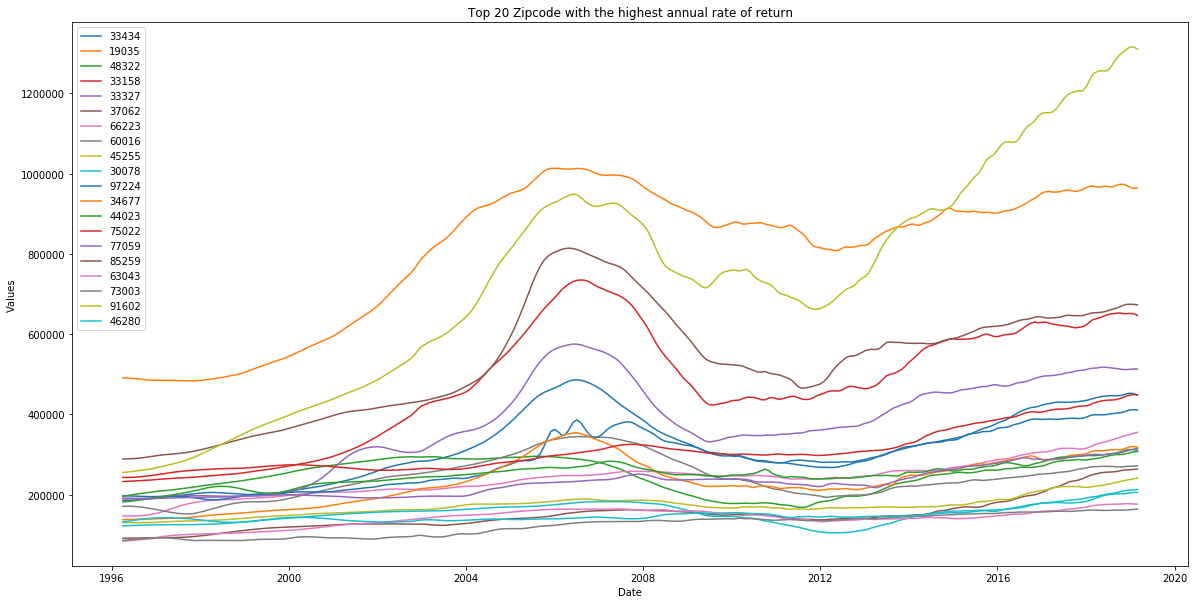

In [9]:

## Explore
plt.figure(figsize=(20,10))
for zip in top20_zips:
  ax = sns.lineplot('Date', 'Values',label = zip, data= single_family[single_family['Zipcode'] ==  zip])
plt.title("Top 20 Zipcode with the highest annual rate of return")
plt.show()

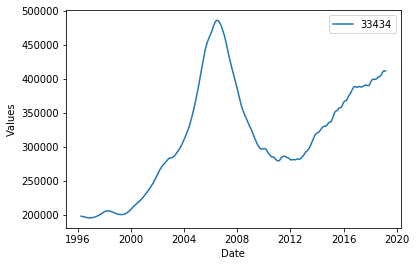

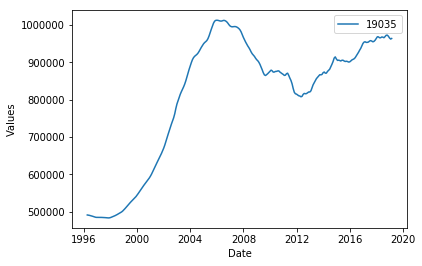

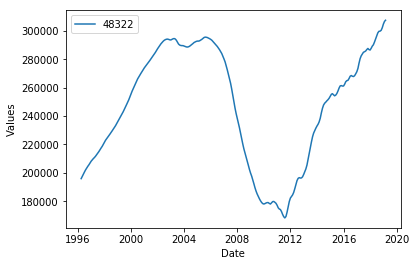

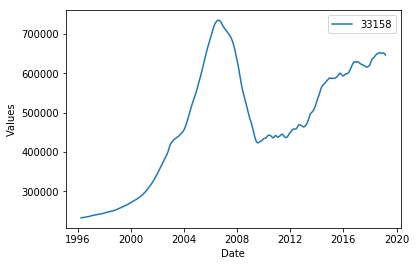

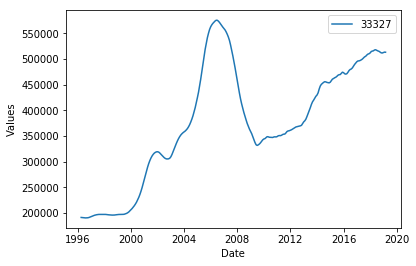

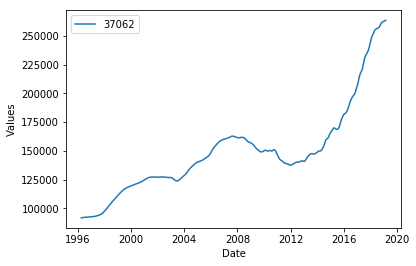

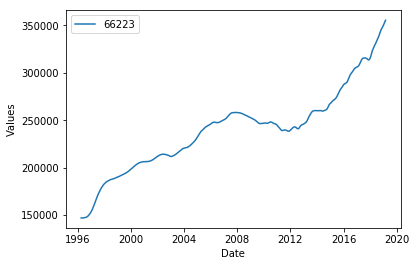

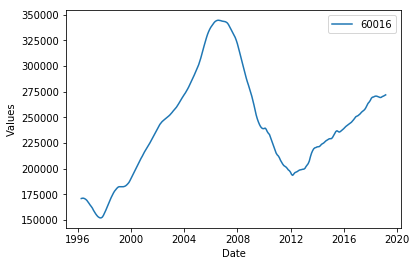

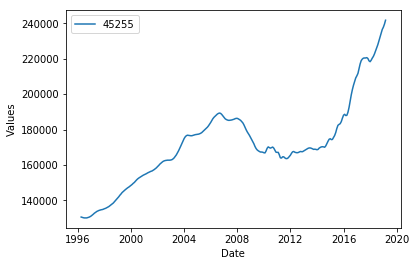

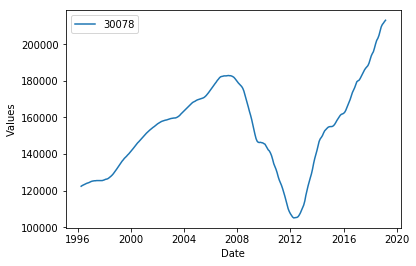

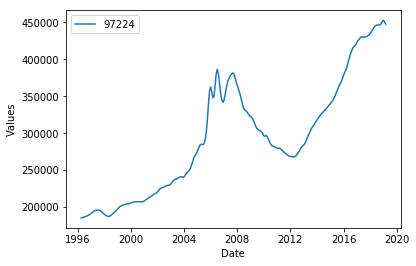

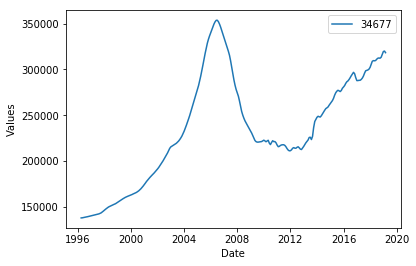

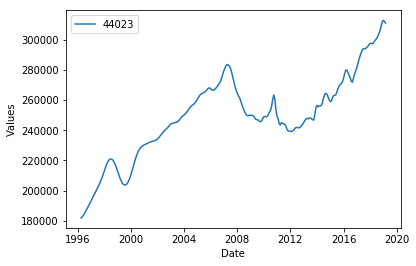

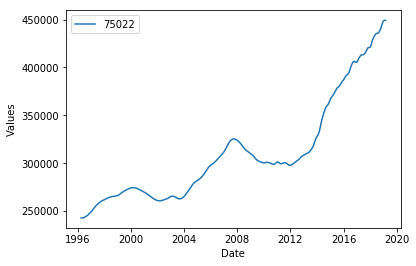

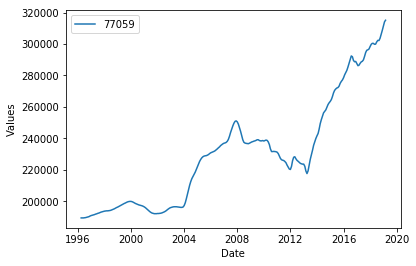

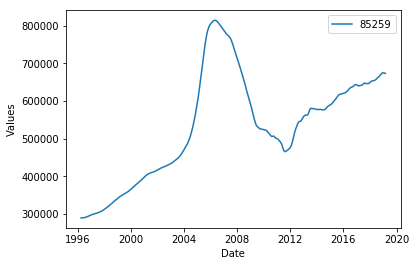

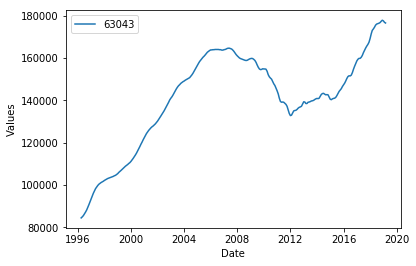

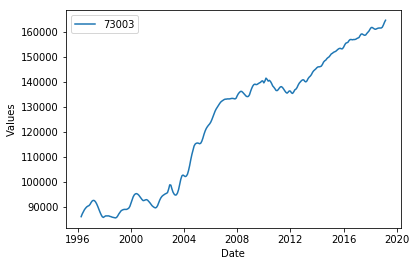

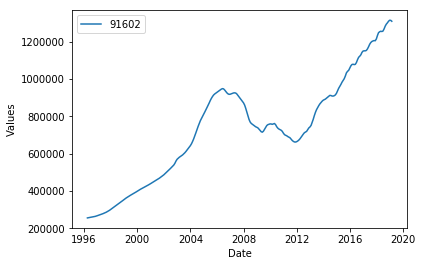

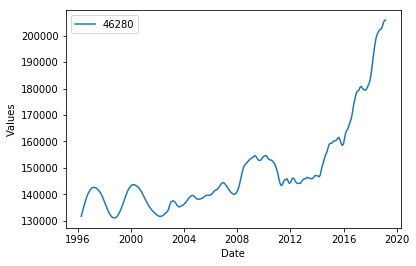

In [10]:

## Explore

for zip in top20_zips:
  ax = sns.lineplot('Date', 'Values',label = zip, data= single_family[single_family['Zipcode'] ==  zip])
  plt.show()
           


In [0]:

top_10 = ['33434', '19035', '48322','33158', '33327','37062','66223','60016','45255','30078']

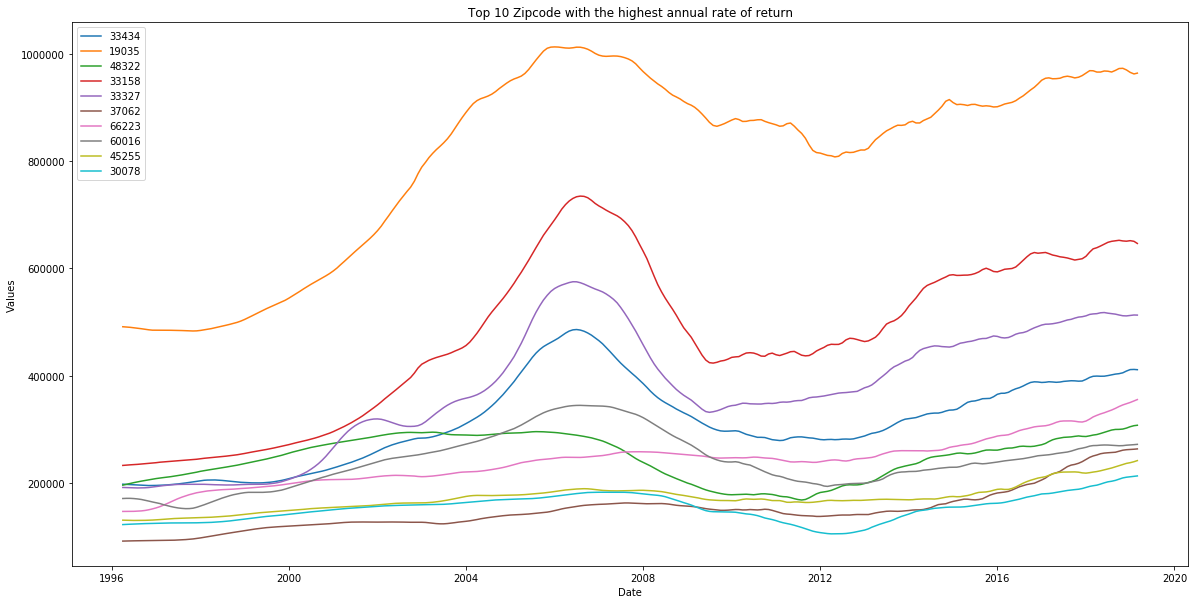

In [12]:
plt.figure(figsize=(20,10))
for zip in top_10:
  ax = sns.lineplot('Date', 'Values',label = zip, data= single_family[single_family['Zipcode'] ==  zip])
plt.title("Top 10 Zipcode with the highest annual rate of return")
plt.show()

## Load datasets with geometry created from the r-scripts 

In [13]:
new_df = pd.read_csv('single_family_with_geo.csv')
new_df.head()

Unnamed: 0 State  RegionName        X  ...  state   latitude  longitude statename
0           1    AK       99501  3380471  ...     AK  61.216799 -149.87828    Alaska
1           2    AK       99501   857068  ...     AK  61.216799 -149.87828    Alaska
2           3    AK       99501  1739485  ...     AK  61.216799 -149.87828    Alaska
3           4    AK       99501  2977965  ...     AK  61.216799 -149.87828    Alaska
4           5    AK       99501  2714788  ...     AK  61.216799 -149.87828    Alaska

[5 rows x 18 columns]

In [14]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865932 entries, 0 to 3865931
Data columns (total 18 columns):
Unnamed: 0    int64
State         object
RegionName    int64
X             int64
RegionID      int64
City          object
Metro         object
CountyName    object
SizeRank      int64
Date          datetime64[ns]
Values        float64
year          int64
month         int64
city          object
state         object
latitude      float64
longitude     float64
statename     object
dtypes: datetime64[ns](1), float64(3), int64(7), object(7)
memory usage: 530.9+ MB


In [18]:
## groupby state, date and month

df_med_state = new_df.groupby(['State', 'Date', 'month']).median().reset_index()
df_med_state.head()

State       Date  month  Unnamed: 0  ...    Values    year   latitude   longitude
0    AK 1996-04-01      4      3840.5  ...  118800.0  1996.0  61.172421 -149.663165
1    AK 1996-05-01      5      3925.5  ...  119450.0  1996.0  61.172421 -149.663165
2    AK 1996-06-01      6      3881.5  ...  120150.0  1996.0  61.172421 -149.663165
3    AK 1996-07-01      7      3909.5  ...  120850.0  1996.0  61.172421 -149.663165
4    AK 1996-08-01      8      3882.0  ...  121300.0  1996.0  61.172421 -149.663165

[5 rows x 12 columns]

In [19]:
#describe
df_med_state.describe()

month    Unnamed: 0  ...      latitude     longitude
count  11868.000000  1.186800e+04  ...  11868.000000  11868.000000
mean       6.500000  1.911528e+06  ...     38.930774    -96.944566
std        3.452198  1.140788e+06  ...      6.312833     18.291278
min        1.000000  3.732000e+03  ...     21.330700   -157.830660
25%        3.750000  9.624496e+05  ...     35.262548   -106.631070
50%        6.500000  1.940418e+06  ...     39.147764    -92.620790
75%        9.250000  2.905944e+06  ...     42.751576    -84.148620
max       12.000000  3.861636e+06  ...     61.172421    -74.150980

[8 rows x 10 columns]

In [23]:
df_med_state['year'] = pd.DatetimeIndex(df_med_state['Date']).year
df_med_state['month'] = pd.DatetimeIndex(df_med_state['Date']).month

df_med_state.head()

State       Date  month  Unnamed: 0  ...    Values  year   latitude   longitude
0    AK 1996-04-01      4      3840.5  ...  118800.0  1996  61.172421 -149.663165
1    AK 1996-05-01      5      3925.5  ...  119450.0  1996  61.172421 -149.663165
2    AK 1996-06-01      6      3881.5  ...  120150.0  1996  61.172421 -149.663165
3    AK 1996-07-01      7      3909.5  ...  120850.0  1996  61.172421 -149.663165
4    AK 1996-08-01      8      3882.0  ...  121300.0  1996  61.172421 -149.663165

[5 rows x 12 columns]

In [27]:
## subset dec 2018 datasets

df_dec_2018 = df_med_state[(df_med_state['year'] == 2018) & (df_med_state['month'] == 12)]
df_dec_2018.head()

State       Date  month  Unnamed: 0  ...    Values  year   latitude   longitude
272     AK 2018-12-01     12      3864.0  ...  309650.0  2018  61.172421 -149.663165
548     AL 2018-12-01     12     37909.5  ...  139250.0  2018  33.341954  -86.676400
824     AR 2018-12-01     12     85560.5  ...  129500.0  2018  35.352565  -92.620790
1100    AZ 2018-12-01     12    135478.5  ...  249700.0  2018  33.460417 -111.890180
1376    CA 2018-12-01     12    337823.0  ...  570800.0  2018  35.262548 -119.240270

[5 rows x 12 columns]

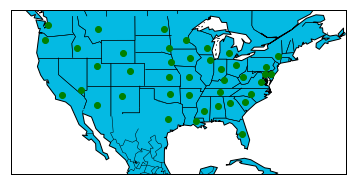

In [45]:
## basemap
plt.figure()

m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')

m.drawcoastlines()
m.drawstates()
#m.drawcountries()
m.fillcontinents(color='#04BAE3', lake_color='#FFFFFF')
m.drawmapboundary(fill_color='#FFFFFF')

lat, lon = df_dec_2018['latitude'].values, df_dec_2018['longitude'].values

x,y = m(lon,lat)

m.plot(x,y,'go')
plt.show()

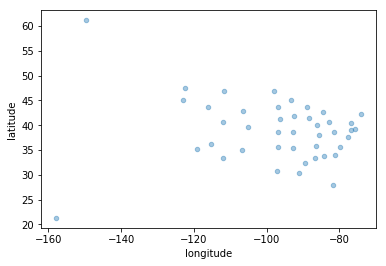

In [44]:
df_dec_2018.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.show()

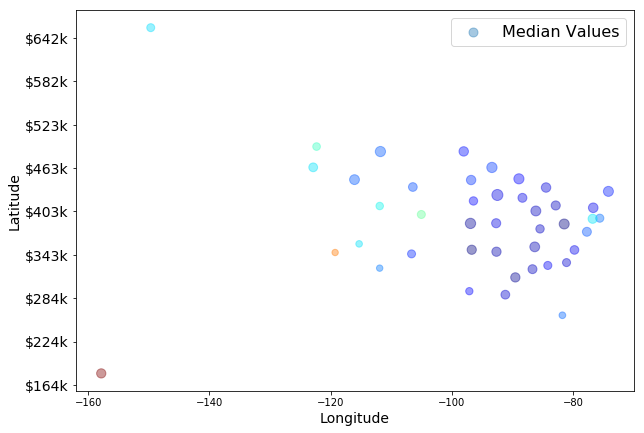

In [39]:
import numpy as np
import matplotlib.image as mpimg
#california_img=mpimg.imread('california.png')

ax = df_dec_2018.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s= df_dec_2018['SizeRank']/100, label="Median Values",
                       c="Values", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
#plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df_dec_2018["Values"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
#cbar = plt.colorbar()
ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
#ax.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

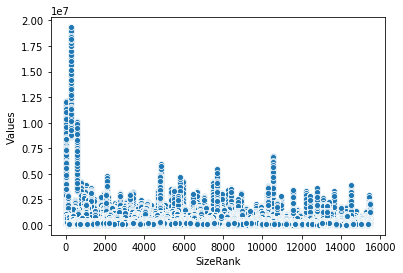

In [46]:
sns.scatterplot(new_df.SizeRank, new_df.Values)

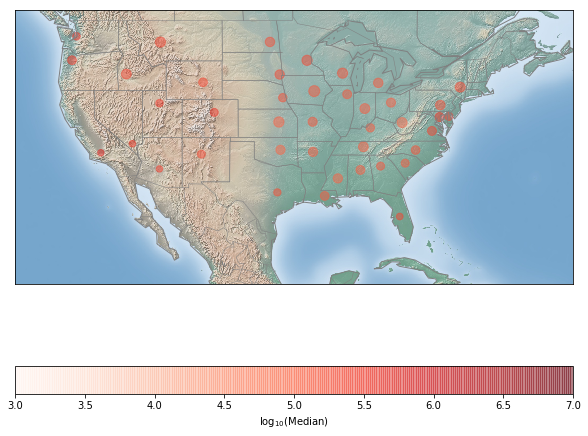

In [67]:
# Extract the data we're interested in
lat = df_dec_2018['latitude'].values
lon = df_dec_2018['longitude'].values
median = df_dec_2018['Values'].values
sizerank = df_dec_2018['SizeRank'].values


# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
#m = Basemap(projection='lcc', resolution='h', lat_0=37.5, lon_0=-119, width=1E6, height=1.2E6)
m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, c=np.log10(median), s=sizerank/100, cmap='Reds', alpha=0.5)
#m.scatter(lon, lat, latlon=True, c=np.log10(sizerank), cmap='Greens', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm Median})$',orientation='horizontal')
plt.clim(3, 7)

# make legend with dummy points
#for a in [100, 300, 500]:
    #plt.scatter([], [], c='k', alpha=0.5, s=a,label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='best')
plt.show()

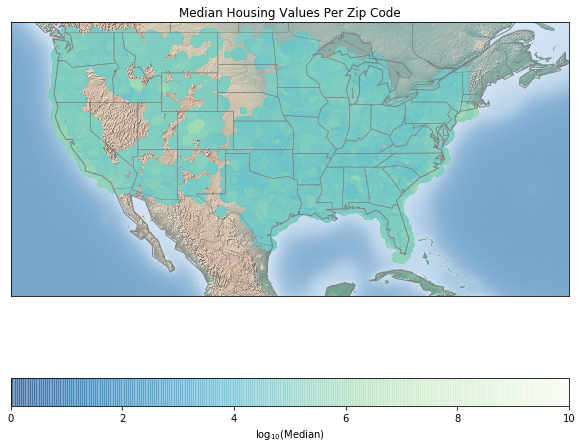

In [70]:
# Extract the data we're interested in
lat = new_df['latitude'].values
lon = new_df['longitude'].values
median = new_df['Values'].values
sizerank = new_df['SizeRank'].values



# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
#m = Basemap(projection='lcc', resolution='h', lat_0=37.5, lon_0=-119, width=1E6, height=1.2E6)
m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, c=np.log10(median), s=sizerank/100, cmap='GnBu_r', alpha=0.5)
#m.scatter(lon, lat, latlon=True, c=np.log10(sizerank), cmap='Greens', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm Median})$',orientation='horizontal')
plt.clim(0, 10)

# make legend with dummy points
#for a in [100, 300, 500]:
    #plt.scatter([], [], c='k', alpha=0.5, s=a,label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='best')
plt.title('Median Housing Values Per Zip Code')
plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.195000e+03, 1.055070e+05, 1.071203e+06, 1.607711e+06,
        6.665130e+05, 1.978300e+05, 3.023900e+04, 6.497000e+03,
        6.080000e+02, 2.630000e+02]),
 array([ 9.32366906, 10.06906093, 10.81445281, 11.55984468, 12.30523655,
        13.05062843, 13.7960203 , 14.54141218, 15.28680405, 16.03219593,
        16.7775878 ]),
 <a list of 10 Patch objects>)

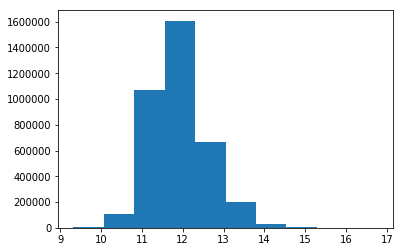

In [71]:
plt.hist(np.log(new_df.Values))

In [72]:
## Group by metro

df_metro = new_df.groupby(['Metro', 'Date']).median().reset_index()
df_metro.head()

Metro       Date  Unnamed: 0  ...  month   latitude   longitude
0  Aberdeen 1996-04-01   3681584.0  ...    4.0  46.978421 -123.754965
1  Aberdeen 1996-05-01   3681614.0  ...    5.0  46.978421 -123.754965
2  Aberdeen 1996-06-01   3681482.0  ...    6.0  46.978421 -123.754965
3  Aberdeen 1996-07-01   3681544.5  ...    7.0  46.978421 -123.754965
4  Aberdeen 1996-08-01   3681493.0  ...    8.0  46.978421 -123.754965

[5 rows x 12 columns]

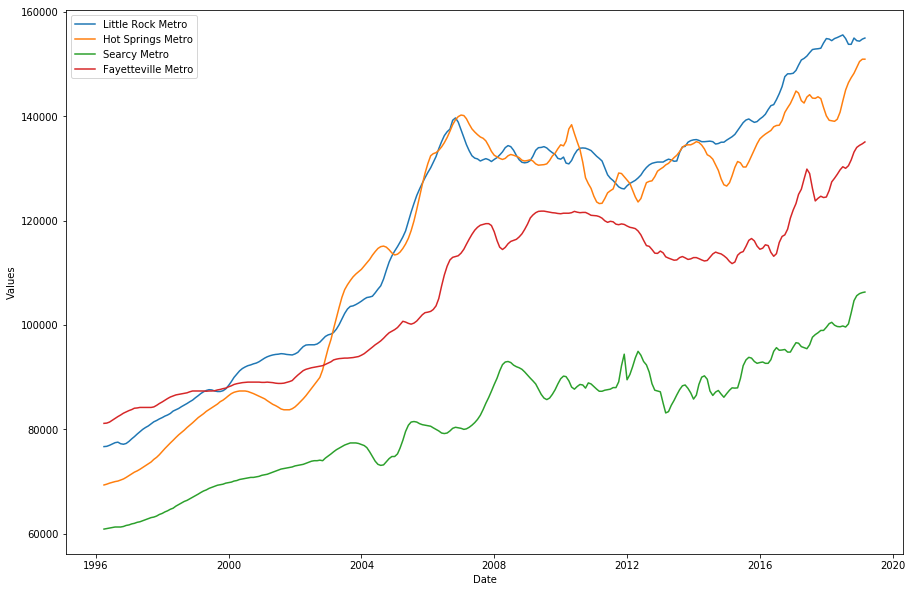

In [73]:

## 
plt.figure(figsize= (15,10))

#ax = sns.lineplot(x="Date", y="Values",label='Ada Metro',data=df_metro.query("Metro == 'Ada'"))
ax = sns.lineplot(x="Date", y="Values",label='Little Rock Metro',data=df_metro.query("Metro == 'Little Rock-North Little Rock-Conway'"))
ax = sns.lineplot(x="Date", y="Values",label='Hot Springs Metro',data=df_metro.query("Metro == 'Hot Springs'"))
ax = sns.lineplot(x="Date", y="Values",label='Searcy Metro',data=df_metro.query("Metro == 'Searcy'"))
ax = sns.lineplot(x="Date", y="Values",label='Fayetteville Metro',data=df_metro.query("Metro == 'Fayetteville'"))


plt.show()

In [0]:
cur.execute('SELECT zip, mse from models_log')

data = cur.fetchall()

In [75]:
df_mse = pd.DataFrame(data = data, columns=['zip','mse'])
df_mse.head()

zip       mse
0  60657  0.000149
1  77494  0.001895
2  60614  0.000154
3  77449  0.003275
4  79936  0.001303

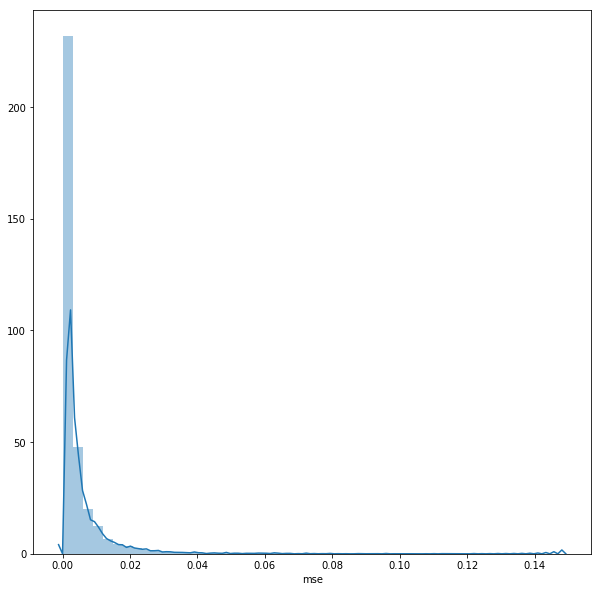

In [76]:
plt.figure(figsize = (10,10))
sns.distplot(df_mse['mse'])
plt.show()

In [81]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865932 entries, 0 to 3865931
Data columns (total 18 columns):
Unnamed: 0    int64
State         object
RegionName    int64
X             int64
RegionID      int64
City          object
Metro         object
CountyName    object
SizeRank      int64
Date          datetime64[ns]
Values        float64
year          int64
month         int64
city          object
state         object
latitude      float64
longitude     float64
statename     object
dtypes: datetime64[ns](1), float64(3), int64(7), object(7)
memory usage: 530.9+ MB


In [82]:
## add mse to the new_df dataframe
df_mse['zip'] = df_mse['zip'].astype(str)
new_df['RegionName'] = new_df['RegionName'].astype(str)

new_df_with_mse = new_df.merge(df_mse,left_on='RegionName', right_on='zip')

new_df_with_mse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3865932 entries, 0 to 3865931
Data columns (total 20 columns):
Unnamed: 0    int64
State         object
RegionName    object
X             int64
RegionID      int64
City          object
Metro         object
CountyName    object
SizeRank      int64
Date          datetime64[ns]
Values        float64
year          int64
month         int64
city          object
state         object
latitude      float64
longitude     float64
statename     object
zip           object
mse           float64
dtypes: datetime64[ns](1), float64(4), int64(6), object(9)
memory usage: 619.4+ MB


In [83]:
new_df_with_mse.head()

Unnamed: 0 State RegionName        X  ...  longitude statename    zip       mse
0           1    AK      99501  3380471  ... -149.87828    Alaska  99501  0.000739
1           2    AK      99501   857068  ... -149.87828    Alaska  99501  0.000739
2           3    AK      99501  1739485  ... -149.87828    Alaska  99501  0.000739
3           4    AK      99501  2977965  ... -149.87828    Alaska  99501  0.000739
4           5    AK      99501  2714788  ... -149.87828    Alaska  99501  0.000739

[5 rows x 20 columns]

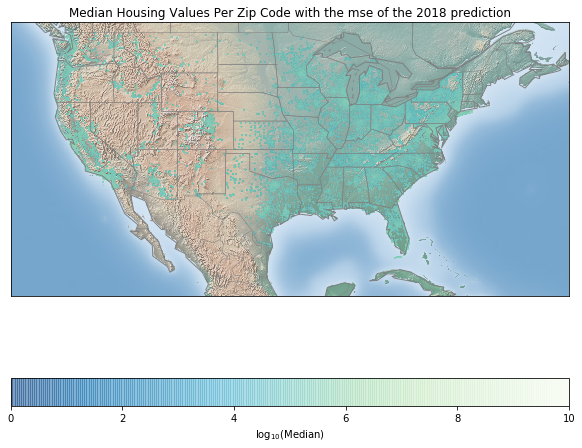

In [86]:
# Extract the data we're interested in
lat = new_df_with_mse['latitude'].values
lon = new_df_with_mse['longitude'].values
values = new_df_with_mse['Values'].values
mse = new_df_with_mse['mse'].values



# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
#m = Basemap(projection='lcc', resolution='h', lat_0=37.5, lon_0=-119, width=1E6, height=1.2E6)
m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, c=np.log10(values), s= (np.exp(mse))/100, cmap='GnBu_r', alpha=0.5)
#m.scatter(lon, lat, latlon=True, c=np.log10(sizerank), cmap='Greens', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm Median})$',orientation='horizontal')
plt.clim(0, 10)

# make legend with dummy points
#for a in [100, 300, 500]:
    #plt.scatter([], [], c='k', alpha=0.5, s=a,label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='best')
plt.title('Median Housing Values Per Zip Code with the mse of the 2018 prediction')
plt.show()


In [87]:
df_top20_with_mse = new_df_with_mse[new_df_with_mse['zip'].isin(top20_zips)]

print(df_top20_with_mse.shape)
print(len(df_top20_with_mse.zip.unique()))

(5520, 20)
20


In [91]:
df_top20_with_mse['Metro'].unique()

array(['Phoenix-Mesa-Scottsdale', 'Los Angeles-Long Beach-Anaheim',
       'Miami-Fort Lauderdale-West Palm Beach',
       'Tampa-St. Petersburg-Clearwater', 'Atlanta-Sandy Springs-Roswell',
       'Chicago-Naperville-Elgin', 'Indianapolis-Carmel-Anderson',
       'Kansas City', 'Detroit-Warren-Dearborn', 'St. Louis',
       'Cleveland-Elyria', 'Cincinnati', 'Oklahoma City',
       'Portland-Vancouver-Hillsboro', 'Philadelphia-Camden-Wilmington',
       'Nashville-Davidson--Murfreesboro--Franklin',
       'Dallas-Fort Worth-Arlington', 'Houston-The Woodlands-Sugar Land'],
      dtype=object)

In [94]:
df_top20_with_mse.head()

Unnamed: 0 State RegionName  ...  statename    zip       mse
123372      123373    AZ      85259  ...    Arizona  85259  0.000207
123373      123374    AZ      85259  ...    Arizona  85259  0.000207
123374      123375    AZ      85259  ...    Arizona  85259  0.000207
123375      123376    AZ      85259  ...    Arizona  85259  0.000207
123376      123377    AZ      85259  ...    Arizona  85259  0.000207

[5 rows x 20 columns]

In [92]:
print(len(df_top20_with_mse['Metro'].unique()))

18


In [93]:
df_top20_with_mse['City'].unique()

array(['Scottsdale', 'Los Angeles', 'Village of Palmetto Bay', 'Weston',
       'Boca Raton', 'Oldsmar', 'Snellville', 'Des Plaines',
       'Indianapolis', 'Overland Park', 'West Bloomfield',
       'Maryland Heights', 'Chagrin Falls', 'Cincinnati', 'Edmond',
       'Tigard', 'Lower Merion', 'Fairview', 'Flower Mound', 'Houston'],
      dtype=object)

In [98]:
# group by metro

df_top20_with_mse_metro = df_top20_with_mse.groupby(['Metro','Date']).median().reset_index()
df_top20_with_mse_metro.head()

Metro       Date  ...  longitude       mse
0  Atlanta-Sandy Springs-Roswell 1996-04-01  ...  -84.01807  0.000226
1  Atlanta-Sandy Springs-Roswell 1996-05-01  ...  -84.01807  0.000226
2  Atlanta-Sandy Springs-Roswell 1996-06-01  ...  -84.01807  0.000226
3  Atlanta-Sandy Springs-Roswell 1996-07-01  ...  -84.01807  0.000226
4  Atlanta-Sandy Springs-Roswell 1996-08-01  ...  -84.01807  0.000226

[5 rows x 12 columns]

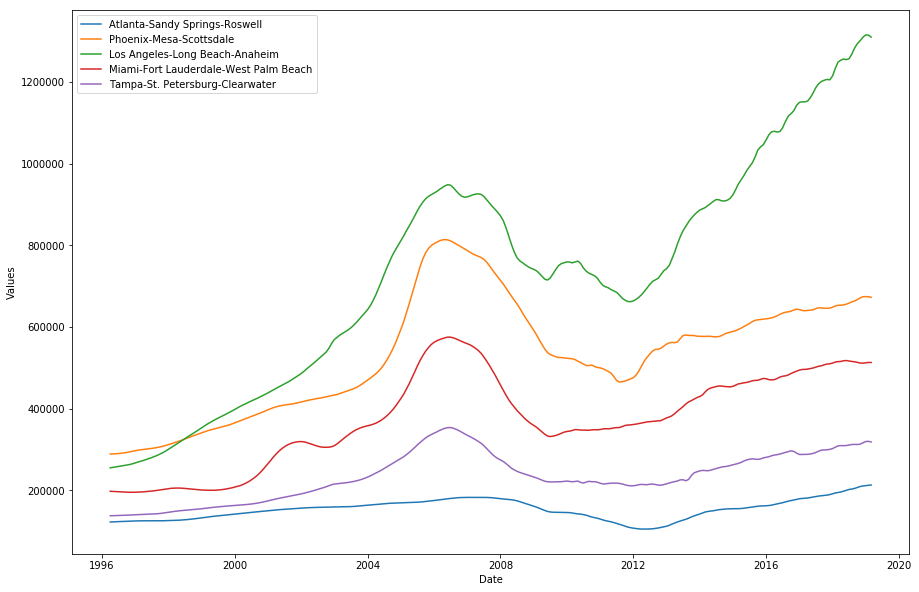

In [101]:

## 
plt.figure(figsize= (15,10))

ax = sns.lineplot(x="Date", y="Values",label='Atlanta-Sandy Springs-Roswell',data=df_top20_with_mse_metro.query("Metro == 'Atlanta-Sandy Springs-Roswell' "))
ax = sns.lineplot(x="Date", y="Values",label='Phoenix-Mesa-Scottsdale',data=df_top20_with_mse_metro.query("Metro == 'Phoenix-Mesa-Scottsdale' "))
ax = sns.lineplot(x="Date", y="Values",label='Los Angeles-Long Beach-Anaheim',data=df_top20_with_mse_metro.query("Metro == 'Los Angeles-Long Beach-Anaheim' "))
ax = sns.lineplot(x="Date", y="Values",label='Miami-Fort Lauderdale-West Palm Beach',data=df_top20_with_mse_metro.query("Metro == 'Miami-Fort Lauderdale-West Palm Beach' "))
ax = sns.lineplot(x="Date", y="Values",label='Tampa-St. Petersburg-Clearwater',data=df_top20_with_mse_metro.query("Metro == 'Tampa-St. Petersburg-Clearwater' "))


plt.show()

In [0]:
metro = list(df_top20_with_mse['Metro'].unique())

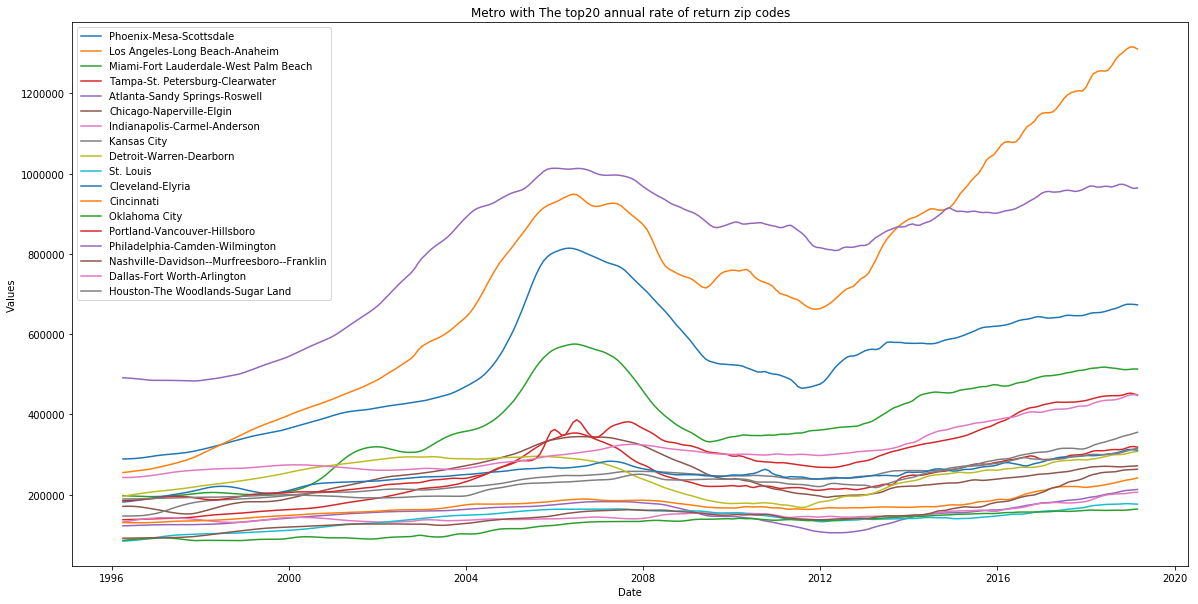

In [104]:

## Explore
plt.figure(figsize=(20,10))
for met in metro:
  ax = sns.lineplot('Date', 'Values',label = met, data= df_top20_with_mse_metro[df_top20_with_mse_metro['Metro'] ==  met])
plt.title("Metro with The top20 annual rate of return zip codes")
plt.show()

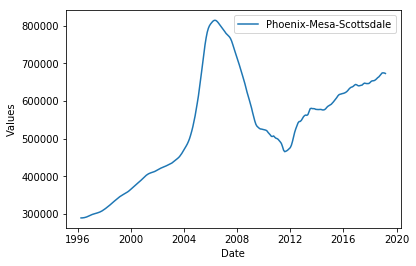

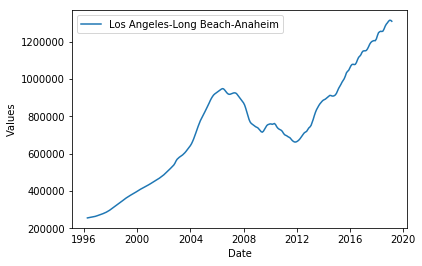

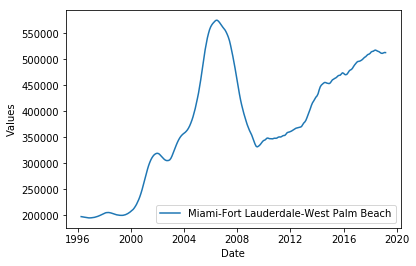

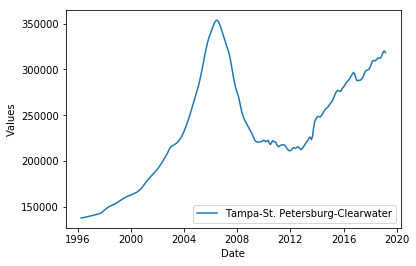

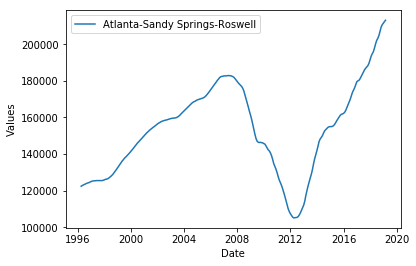

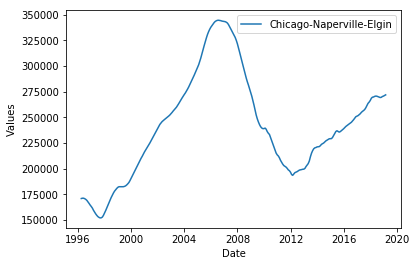

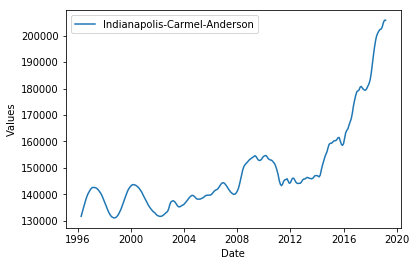

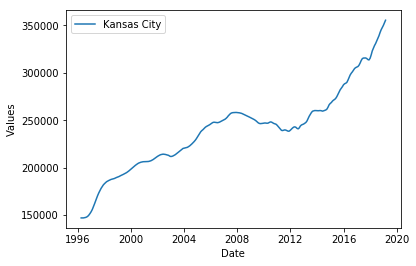

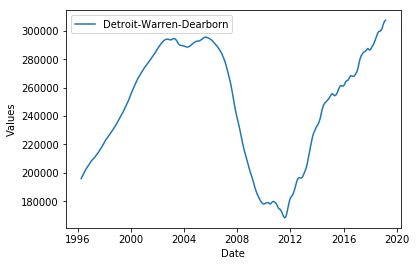

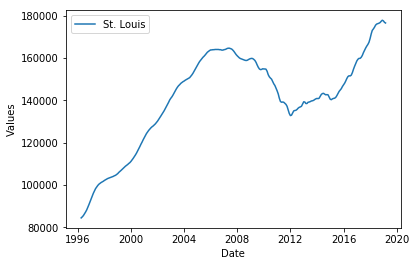

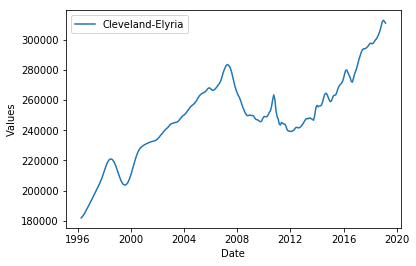

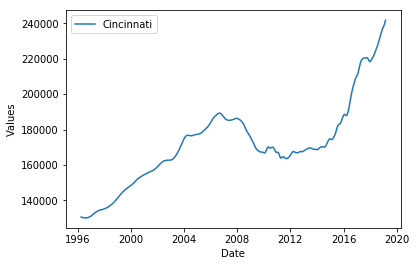

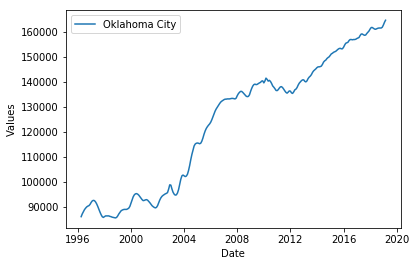

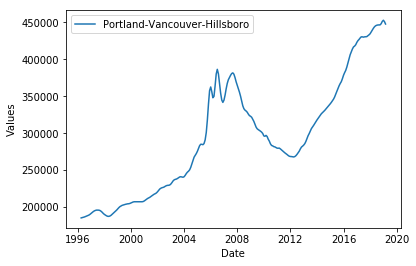

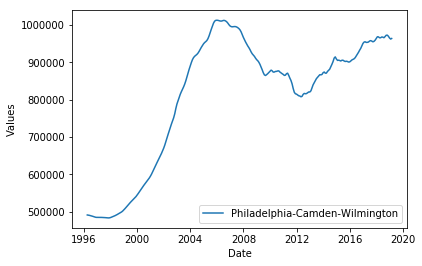

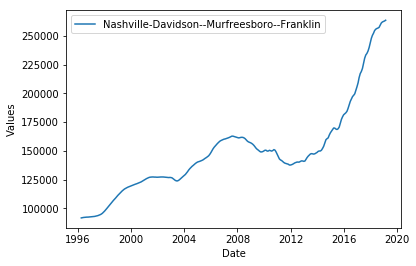

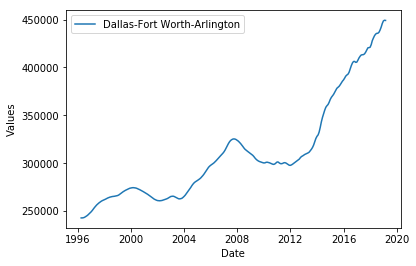

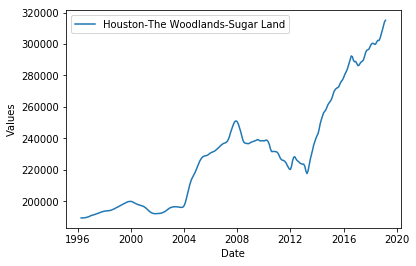

In [106]:
## Explore

for met in metro:
  ax = sns.lineplot('Date', 'Values',label = met, data= df_top20_with_mse_metro[df_top20_with_mse_metro['Metro'] ==  met])
  plt.show()
           

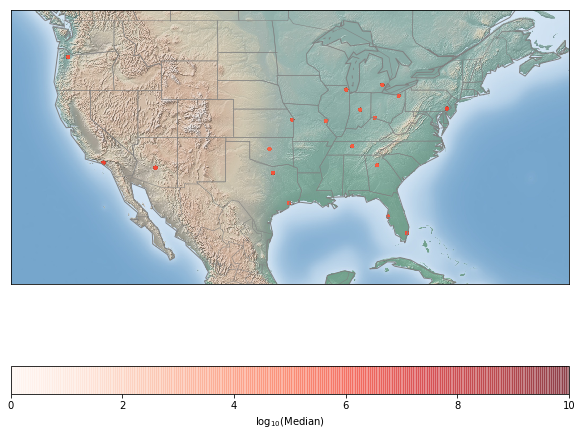

In [116]:
# Extract the data we're interested in
lat = df_top20_with_mse_metro['latitude'].values
lon = df_top20_with_mse_metro['longitude'].values
values = df_top20_with_mse_metro['Values'].values
mse = df_top20_with_mse_metro['mse'].values



# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
#m = Basemap(projection='lcc', resolution='h', lat_0=37.5, lon_0=-119, width=1E6, height=1.2E6)
m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, c=np.log10(values), s= np.log10(values), cmap='Reds', alpha=0.5)
#m.scatter(lon, lat, latlon=True, c=np.log10(sizerank), cmap='Greens', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm Median})$',orientation='horizontal')
plt.clim(0, 10)

# make legend with dummy points
#for a in [100, 300, 500]:
    #plt.scatter([], [], c='k', alpha=0.5, s=a,label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='best')
#plt.title('Median Housing Values Per Zip Code with the mse of the 2018 prediction')
plt.show()


In [123]:
df_top20_with_mse[df_top20_with_mse['Metro'] == 'Kansas City']['zip'].unique()

array(['66223'], dtype=object)

In [124]:
df_top20_with_mse[df_top20_with_mse['Metro'] == 'Oklahoma City']['zip'].unique()

array(['73003'], dtype=object)

In [127]:
df_top20_with_mse[df_top20_with_mse['Metro'] == 'Nashville-Davidson--Murfreesboro--Franklin']['zip'].unique()

array(['37062'], dtype=object)

In [155]:
cur.execute("SELECT model from models_log where zip=73003 ")

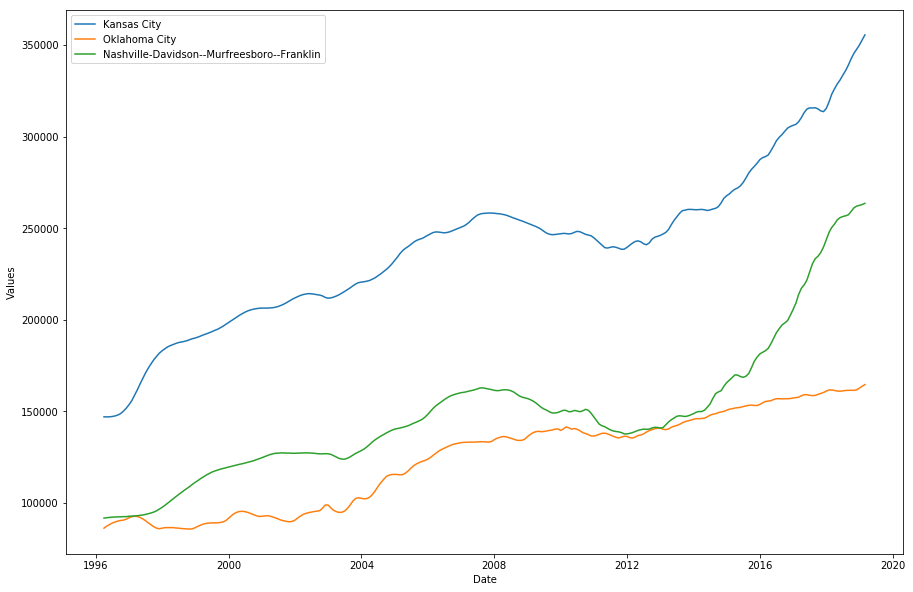

In [161]:

## 
plt.figure(figsize= (15,10))

ax = sns.lineplot(x="Date", y="Values",label='Kansas City',data=df_top20_with_mse_metro.query("Metro == 'Kansas City' "))
ax = sns.lineplot(x="Date", y="Values",label='Oklahoma City',data=df_top20_with_mse_metro.query("Metro == 'Oklahoma City' "))
ax = sns.lineplot(x="Date", y="Values",label='Nashville-Davidson--Murfreesboro--Franklin',data=df_top20_with_mse_metro.query("Metro == 'Nashville-Davidson--Murfreesboro--Franklin' "))
#ax = sns.lineplot(x="Date", y="Values",label='Miami-Fort Lauderdale-West Palm Beach',data=df_top20_with_mse_metro.query("Metro == 'Miami-Fort Lauderdale-West Palm Beach' "))
#ax = sns.lineplot(x="Date", y="Values",label='Tampa-St. Petersburg-Clearwater',data=df_top20_with_mse_metro.query("Metro == 'Tampa-St. Petersburg-Clearwater' "))


plt.show()

In [0]:


def run_prophet(df):
  print('='*50)
  print("Fitting Model")
  print("="*50)
  model = Prophet(interval_width=0.95)
  model.fit(df)
  print("="*50)
  print("Predicting future dates in an interval of 10 at a monthly frequency")
  print("="*50)
  future_dates = model.make_future_dataframe(periods=10, freq='m')
  print("="*50)
  print("Tail of the feature dates")
  print(future_dates.tail())
  print("="*50)
  print("Forcasting")
  forecast = model.predict(future_dates)
  print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
  print("="*50)
  model.plot(forecast, uncertainty=True)
  plt.show()
  print("="*50)
  print("INTERPRET")
  model.plot_components(forecast)
  plt.show()

In [163]:
single_family = single_family.rename(index=str, columns ={'Date': 'ds', 'Values': 'y'})
single_family.head()

Unnamed: 0 RegionID Zipcode  ... SizeRank         ds         y
0           0    60657   60657  ...        1 1996-04-01  337200.0
1           1    77494   77494  ...        2 1996-04-01  210400.0
2           2    60614   60614  ...        3 1996-04-01  502900.0
3           3    77449   77449  ...        4 1996-04-01   95400.0
4           4    79936   79936  ...        5 1996-04-01   77300.0

[5 rows x 10 columns]

In [164]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

model = Prophet(interval_width=0.95)
model.fit(single_family[single_family['Zipcode'] == '66223'])

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [165]:

future_dates = model.make_future_dataframe(periods=10, freq='m')
future_dates.tail()

ds
281 2019-08-31
282 2019-09-30
283 2019-10-31
284 2019-11-30
285 2019-12-31

In [166]:
# MODEL

forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
281 2019-08-31  356016.958000  350908.371159  360711.060795
282 2019-09-30  356537.176154  351730.123415  361558.650326
283 2019-10-31  357398.260405  352008.216598  362801.796582
284 2019-11-30  359029.513046  353250.527951  364818.565766
285 2019-12-31  361434.049833  355608.066860  367880.537441

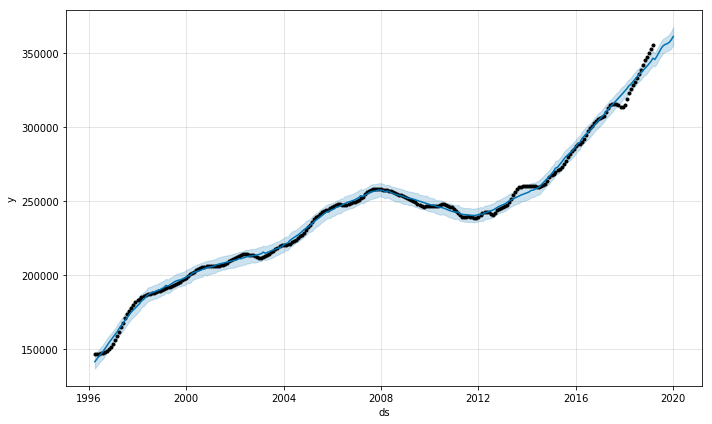

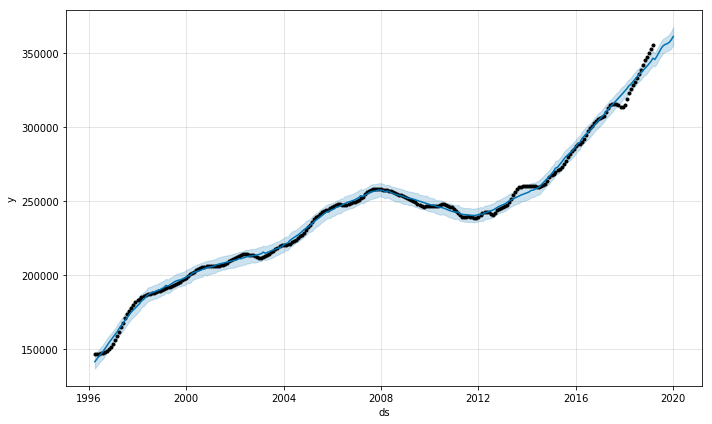

In [167]:

# MODEL

model.plot(forecast, uncertainty=True)

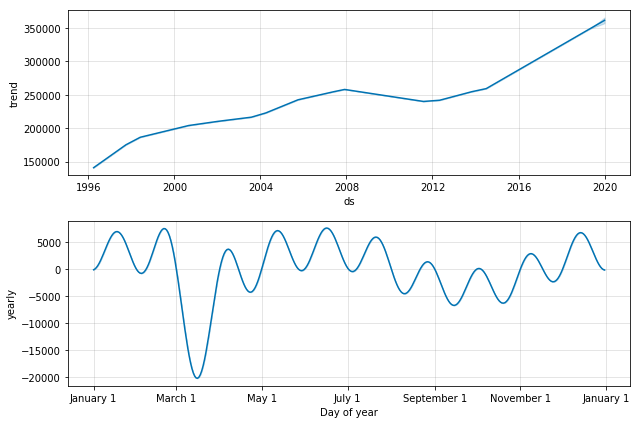

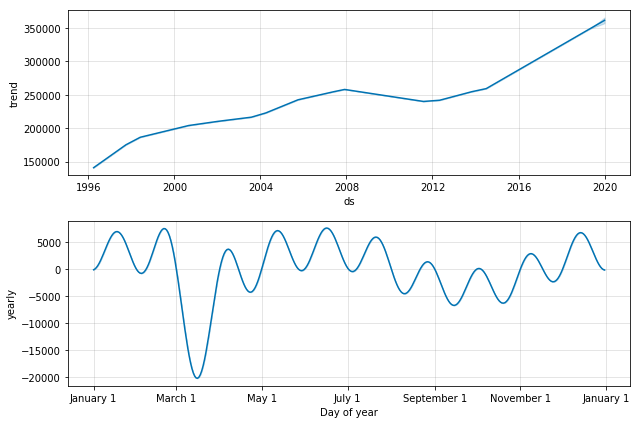

In [168]:
# INTERPRET

model.plot_components(forecast)

In [169]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

model = Prophet(interval_width=0.95)
model.fit(single_family[single_family['Zipcode'] == '73003'])


future_dates = model.make_future_dataframe(periods=10, freq='m')
future_dates.tail()

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
281 2019-08-31
282 2019-09-30
283 2019-10-31
284 2019-11-30
285 2019-12-31

In [170]:
# MODEL

forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



ds           yhat     yhat_lower     yhat_upper
281 2019-08-31  166006.408933  163340.020025  168789.127965
282 2019-09-30  166328.671523  163533.191731  169117.925826
283 2019-10-31  166637.275313  163655.802891  169698.010130
284 2019-11-30  166822.551311  163845.265719  170004.464831
285 2019-12-31  166932.656947  163683.717579  170347.554358

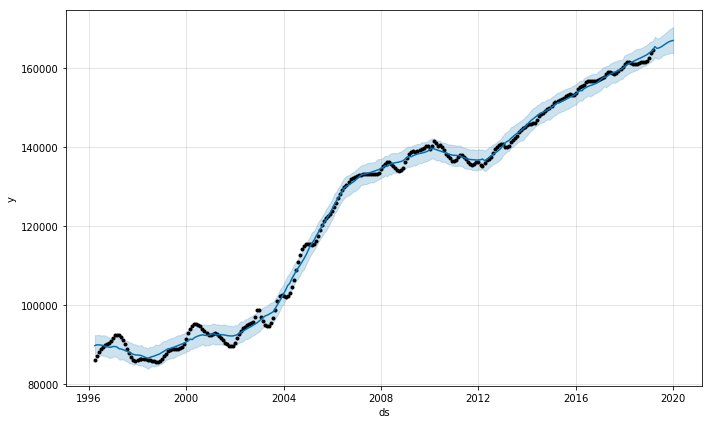

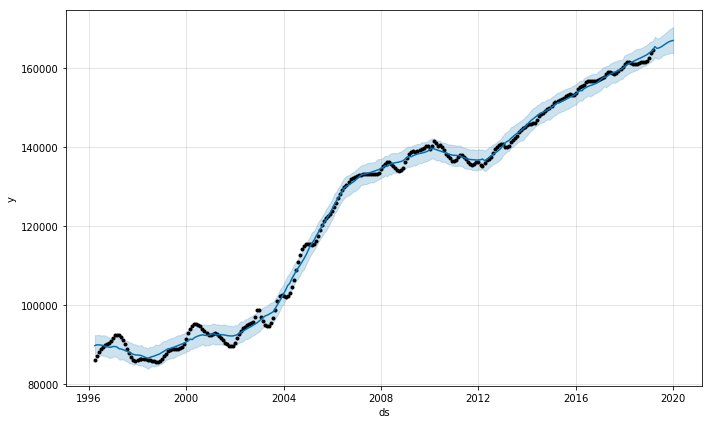

In [171]:

# MODEL

model.plot(forecast, uncertainty=True)

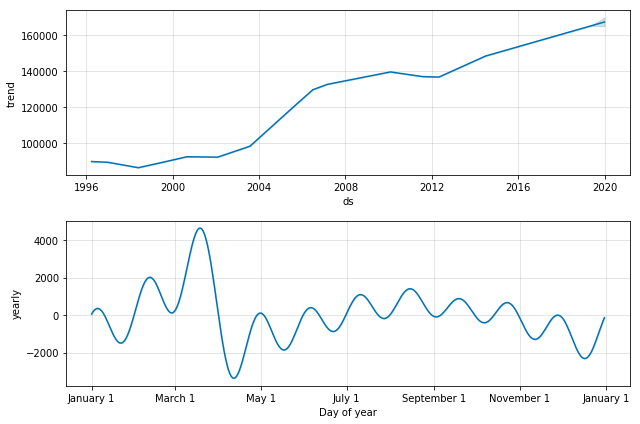

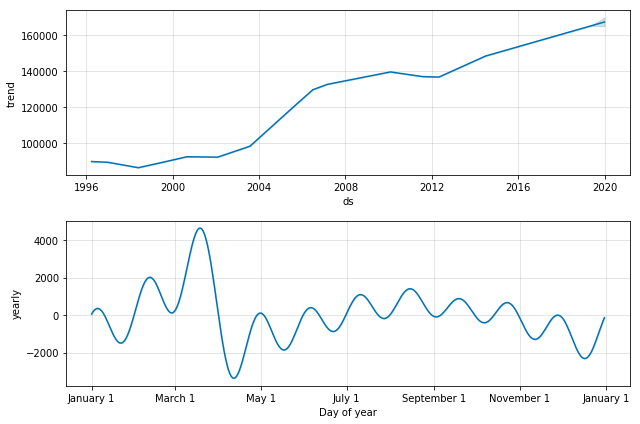

In [172]:
# INTERPRET

model.plot_components(forecast)

In [173]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

model = Prophet(interval_width=0.95)
model.fit(single_family[single_family['Zipcode'] == '37062'])


future_dates = model.make_future_dataframe(periods=10, freq='m')
future_dates.tail()

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
281 2019-08-31
282 2019-09-30
283 2019-10-31
284 2019-11-30
285 2019-12-31

In [174]:
# MODEL

forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
281 2019-08-31  280402.187947  274754.763428  286168.501755
282 2019-09-30  283386.458655  277358.117944  289477.167000
283 2019-10-31  285684.121539  279595.803020  291916.048079
284 2019-11-30  286561.236510  280089.771902  293168.697046
285 2019-12-31  287314.984384  280735.376897  294061.621421

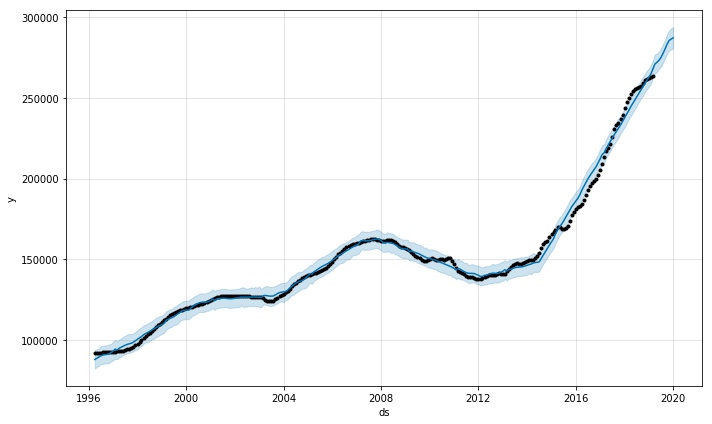

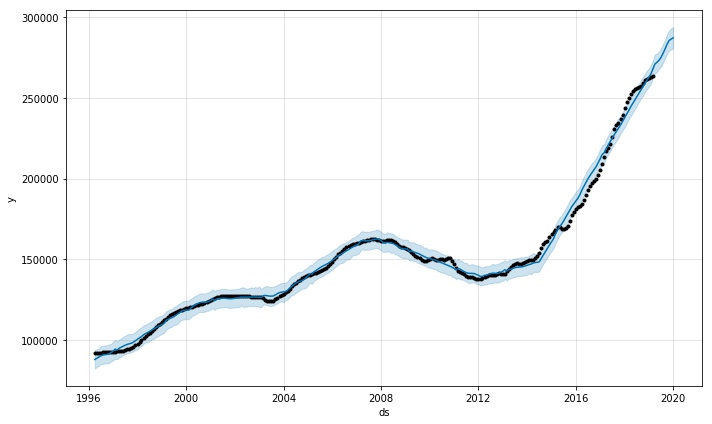

In [175]:
# MODEL

model.plot(forecast, uncertainty=True)

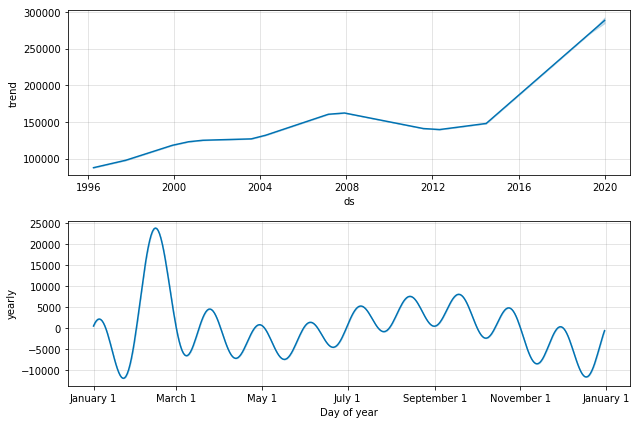

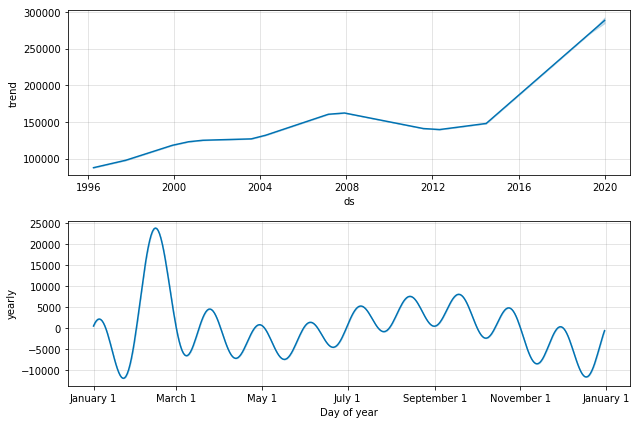

In [176]:
# INTERPRET

model.plot_components(forecast)

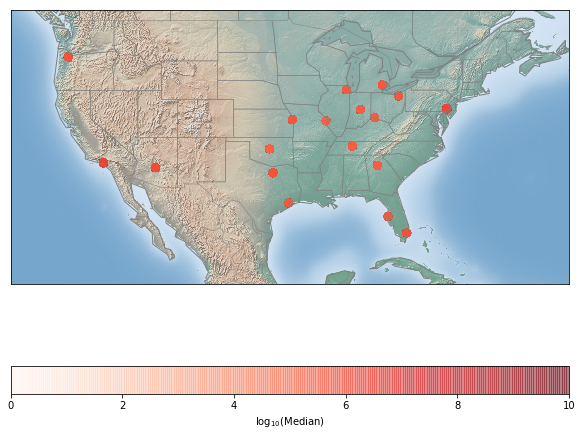

In [184]:
# Extract the data we're interested in
lat = df_top20_with_mse_metro['latitude'].values
lon = df_top20_with_mse_metro['longitude'].values
values = df_top20_with_mse_metro['Values'].values
mse = df_top20_with_mse_metro['mse'].values



# 1. Draw the map background
fig = plt.figure(figsize=(10, 10))
#m = Basemap(projection='lcc', resolution='h', lat_0=37.5, lon_0=-119, width=1E6, height=1.2E6)
m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True, c=np.log10(values), s= np.log10(values) * 10, cmap='Reds', alpha=0.5)
#m.scatter(lon, lat, latlon=True, c=np.log10(sizerank), cmap='Greens', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm Median})$',orientation='horizontal')
plt.clim(0, 10)

# make legend with dummy points
#for a in [100, 300, 500]:
    #plt.scatter([], [], c='k', alpha=0.5, s=a,label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='best')
#plt.title('Median Housing Values Per Zip Code with the mse of the 2018 prediction')
plt.show()

In [0]:
df_top20_with_mse.to_csv('df_top20_with_mse.csv')

In [0]:
new_df_with_mse.to_csv('new_df_with_mse.csv')

In [187]:
cur.execute('SELECT mse from models_log where zip =66223 ')
for data in cur:
  print(data)

(0.000297,)


In [188]:
cur.execute('SELECT mse from models_log where zip =73003 ')
for data in cur:
  print(data)

(0.000269,)


In [189]:
cur.execute('SELECT mse from models_log where zip =37062 ')
for data in cur:
  print(data)

(0.001786,)
